# Teaching an RNN to sketch a circle

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib notebook

In [2]:
class MNISTWorld():
    def __init__(self):
        self.side = 28
        self.max_steps = 4*self.side
        self.mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
        self.reset()
        
    def move_pen(self, action):
        if action is 0:
            self.pen_coord += np.asarray([0,1])
        elif action is 1:
            self.pen_coord += np.asarray([1,1])
        elif action is 2:
            self.pen_coord += np.asarray([1,0])
        elif action is 3:
            self.pen_coord += np.asarray([1,-1])
        elif action is 4:
            self.pen_coord += np.asarray([0,-1])
        elif action is 5:
            self.pen_coord += np.asarray([-1,-1])
        elif action is 6:
            self.pen_coord += np.asarray([-1,0])
        else:
            self.pen_coord += np.asarray([-1,1])
        
        r1 = 0
        if np.min(self.pen_coord) < 0 or np.max(self.pen_coord) >= self.side:
            r1 += -5
        self.pen_coord = self.pen_coord % self.side
        self.canvas[self.pen_coord[0], self.pen_coord[1]] = 1
        
        r2 = self.reward()
        r2 = 0 if r2 < 0 else r2
        return r1 + r2
    
    def step(self, action):
        reward = self.move_pen(action)
        
        o1 = (self.template != self.canvas)*self.template
        o2 = np.zeros_like(o1); o2[self.pen_coord[0], self.pen_coord[1]] = 1
        observation = np.concatenate((o1,o2)).ravel().astype(np.float)
        
        done = False if self.global_step < self.max_steps else True
        self.global_step += 1
        info = None
        return observation, reward, done, info
    
    def reset(self):
        self.global_step = 0
        self.pen_coord = np.ones(2) * self.side/2
        self.canvas = np.zeros((self.side, self.side))
        
        batch = self.mnist.train.next_batch(1)
        self.template = np.reshape(batch[0],(self.side,self.side))
        
        self.prev_cost = self.cost()
        
        o1 = (self.template != self.canvas)*self.template
        o2 = np.zeros_like(o1); o2[self.pen_coord[0], self.pen_coord[1]] = 1
        observation = np.concatenate((o1.ravel(),o2.ravel())).astype(np.float)
        return observation
        
    def reward(self):
        cost = self.cost()
        r = -1*(cost - self.prev_cost)
        self.prev_cost = cost
        return r
    
    def cost(self):
        cost = .5*np.sum((self.template - self.canvas)**2) #/ np.sum((self.template - self.canvas) != 0)
        return cost

In [3]:
class Actor():
    def __init__(self, n_obs, h, n_actions):
        self.n_obs = n_obs                  # dimensionality of observations
        self.h = h                          # number of hidden layer neurons
        self.n_actions = n_actions          # number of available actions
        
        self.model = model = {}
        with tf.variable_scope('actor',reuse=False):
            # convolutional layer 1
            self.model['Wc1'] = tf.Variable(tf.truncated_normal([5, 5, 2, 8], stddev=0.1))
            self.model['bc1'] = tf.Variable(tf.constant(0.1, shape=[8]))

            # convolutional layer 2
            self.model['Wc2'] = tf.Variable(tf.truncated_normal([5, 5, 8, 8], stddev=0.1))
            self.model['bc2'] = tf.Variable(tf.constant(0.1, shape=[8]))

            # fully connected 1
            self.model['W3'] = tf.Variable(tf.truncated_normal([7*7*8, 8], stddev=0.1))
            self.model['b3'] = tf.Variable(tf.constant(0.1, shape=[8]))

            # fully connected 2
            self.model['W4'] = tf.Variable(tf.truncated_normal([8, n_actions], stddev=0.1))
            self.model['b4'] = tf.Variable(tf.constant(0.1, shape=[n_actions]))
            
    def policy_forward(self, x):
        x_image = tf.reshape(x, [-1, 28, 28, 2])
                                      
        zc1 = tf.nn.conv2d(x_image, self.model['Wc1'], strides=[1, 1, 1, 1], padding='SAME') + self.model['bc1']
        hc1 = tf.nn.relu(zc1)
        hc1 = tf.nn.max_pool(hc1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        zc2 = tf.nn.conv2d(hc1, self.model['Wc2'], strides=[1, 1, 1, 1], padding='SAME') + self.model['bc2']
        hc2 = tf.nn.relu(zc2)
        hc2 = tf.nn.max_pool(hc2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        print hc2.get_shape()
        
        hc2_flat = tf.reshape(hc2, [-1, 7*7*8])
        h3 = tf.nn.relu(tf.matmul(hc2_flat, self.model['W3']) + self.model['b3'])
        h3 = tf.nn.dropout(h3, 0.9)
        
        h4 = tf.matmul(h3, self.model['W4']) + self.model['b4']
        return tf.nn.softmax(h4)

In [4]:
class Agent():
    def __init__(self, n_obs, n_actions, gamma=0.99, actor_lr = 1e-4, decay=0.95, epsilon = 0.1):
        self.gamma = gamma            # discount factor for reward
        self.epsilon = epsilon
        self.global_step = 0
        self.xs, self.rs, self.ys = [],[],[]
        
        self.actor_lr = actor_lr               # learning rate for policy
        self.decay = decay
        self.n_obs = n_obs                     # dimensionality of observations
        self.n_actions = n_actions             # number of available actions
        self.save_path ='models/pong.ckpt'
        
        # make actor part of brain
        self.actor = Actor(n_obs=self.n_obs, h=200, n_actions=self.n_actions)
        
        #placeholders
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, n_obs],name="x")
        self.y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions],name="y")
        self.r = tf.placeholder(dtype=tf.float32, shape=[None,1], name="r")
        
        #gradient processing (PG magic)
        self.discounted_r = self.discount_rewards(self.r, self.gamma)
        mean, variance= tf.nn.moments(self.discounted_r, [0], shift=None, name="reward_moments")
        self.discounted_r -= mean
        self.discounted_r /= tf.sqrt(variance + 1e-6)
        
        # initialize tf graph
        self.aprob = self.actor.policy_forward(self.x)
        self.loss = tf.nn.l2_loss(self.y-self.aprob)
        self.optimizer = tf.train.RMSPropOptimizer(self.actor_lr, decay=self.decay)
        self.grads = self.optimizer.compute_gradients(self.loss, \
                                    var_list=tf.trainable_variables(), grad_loss=self.discounted_r)
        self.train_op = self.optimizer.apply_gradients(self.grads)

        self.sess = tf.InteractiveSession()
        tf.initialize_all_variables().run()
    
    def act(self, x):
        aprob = self.sess.run(self.aprob, {self.x: x})
        aprob = aprob[0,:]
        action = np.random.choice(self.n_actions,p=aprob) if np.random.rand() > self.epsilon else np.random.randint(self.n_actions)
        
        label = np.zeros_like(aprob) ; label[action] = 1
        self.xs.append(x)
        self.ys.append(label)
        
        return action
    
    def learn(self):
        epx = np.vstack(self.xs)
        epr = np.vstack(self.rs)
        epy = np.vstack(self.ys)
        self.xs, self.rs, self.ys = [],[],[] # reset game history
        
        feed = {self.x: epx, self.r: epr, self.y: epy}
        _ = self.sess.run(self.train_op,feed) # parameter update
        self.global_step += 1
        
    @staticmethod
    def discount_rewards(r, gamma):
        discount_f = lambda a, v: a*gamma + v;
        r_reverse = tf.scan(discount_f, tf.reverse(r,[True, False]))
        discounted_r = tf.reverse(r_reverse,[True, False])
        return discounted_r

In [5]:
def plt_dynamic(x, y, ax, colors=['b']):
    for color in colors:
        ax.plot(x, y, color)
    fig.canvas.draw()

In [6]:
n_obs = 2*28**2   # dimensionality of observations
n_actions = 8
agent = Agent(n_obs, n_actions, gamma = 0.99, actor_lr=1e-3, decay=0.99, epsilon = 0.1)
env = MNISTWorld()

observation = env.reset()
running_reward = None
reward_sum = 0
episode_number = agent.global_step

save_path = 'mnist-models/model.ckpt'
saver = tf.train.Saver(tf.all_variables())

(?, 7, 7, 8)
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
saver = tf.train.Saver(tf.all_variables())
load_was_success = True # yes, I'm being optimistic
try:
    save_dir = '/'.join(save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(agent.sess, load_path)
except:
    print "no saved model to load. starting new session"
    load_was_success = False
else:
    print "loaded model: {}".format(load_path)
    saver = tf.train.Saver(tf.all_variables())
    agent.global_step = int(load_path.split('-')[-1])

no saved model to load. starting new session


In [8]:
total_parameters = 0 ; print "Model overview:"
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "Total of {} parameters".format(total_parameters)

Model overview:
	variable "actor/Variable:0" has 400 parameters
	variable "actor/Variable_1:0" has 8 parameters
	variable "actor/Variable_2:0" has 1600 parameters
	variable "actor/Variable_3:0" has 8 parameters
	variable "actor/Variable_4:0" has 3136 parameters
	variable "actor/Variable_5:0" has 8 parameters
	variable "actor/Variable_6:0" has 64 parameters
	variable "actor/Variable_7:0" has 8 parameters
Total of 5232 parameters


<IPython.core.display.Javascript object>


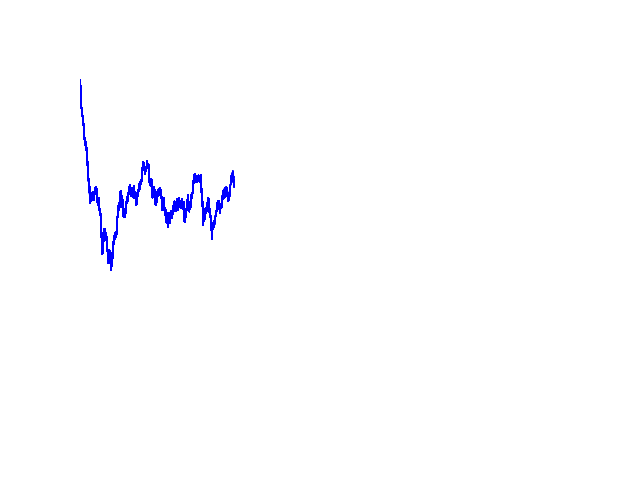

episode 0: starting up...


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ep: 0, reward: 6.64509898424, mean reward: 6.645099


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


	ep: 1, reward: -9.12548947334
	ep: 2, reward: -28.4352939129
	ep: 3, reward: 4.35098105669
	ep: 4, reward: 9.060785532
	ep: 5, reward: 0.223530054092
	ep: 6, reward: -77.0411760211
	ep: 7, reward: -29.0039213896
	ep: 8, reward: -13.1078414321
	ep: 9, reward: 3.0549030304
ep: 10, reward: 7.72353041172, mean reward: 4.749475
	ep: 11, reward: -10.941175878
	ep: 12, reward: -43.1411749125
	ep: 13, reward: -14.5117646456
	ep: 14, reward: -16.9098028541
	ep: 15, reward: 3.50196135044
	ep: 16, reward: -6.3235283494
	ep: 17, reward: 6.09019750357
	ep: 18, reward: 5.19607913494
	ep: 19, reward: 3.30980443954
ep: 20, reward: 10.0823542476, mean reward: 3.719017
	ep: 21, reward: -39.5843123794
	ep: 22, reward: 12.0784329772
	ep: 23, reward: -11.837254405
	ep: 24, reward: -10.7450974584
	ep: 25, reward: -18.394117415
	ep: 26, reward: 4.15098100901
	ep: 27, reward: 6.84509909153
	ep: 28, reward: 7.68039393425
	ep: 29, reward: -46.9901958704
ep: 30, reward: 4.9058830142, mean reward: 2.492259
	ep: 

KeyboardInterrupt: 

In [9]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('X') ; ax.set_ylabel('Y')
ax.set_xlim(0,5000) ; ax.set_ylim(-30,10)
pxs, pys = [], []

print 'episode {}: starting up...'.format(episode_number)
while True:

    # preprocess the observation
    x = observation

    # stochastically sample a policy from the network
    action = agent.act(np.reshape(x, (1,-1)))

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action + 1)
    agent.rs.append(reward)
    reward_sum += reward
    
    if done:
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        agent.learn()

        # visualization
        pxs.append(episode_number)
        pys.append(running_reward)
        if episode_number % 10 == 0:
            print 'ep: {}, reward: {}, mean reward: {:3f}'.format(episode_number, reward_sum, running_reward)
            plt_dynamic(pxs, pys, ax)
        else:
            print '\tep: {}, reward: {}'.format(episode_number, reward_sum)
            plt_dynamic(pxs, pys, ax)
#             feed = {agent.x: np.reshape(x, (1,-1))}
#             aprob = agent.sess.run(agent.aprob, feed) ; aprob = aprob[0,:]
#             print'\t', aprob
            
#         if episode_number % 50 == 0: agent.save() ; print "SAVED MODEL #{}".format(agent.global_step)
        
        # lame stuff
        cur_x = None
        episode_number += 1 # the Next Episode
        observation = env.reset() # reset env
        reward_sum = 0

In [10]:
saver.save(agent.sess, save_path, global_step=agent.global_step)

'mnist-models/model.ckpt-2116'

In [11]:
%matplotlib inline
print np.vstack(agent.rs).T
print agent.discounted_r.eval({agent.r:np.vstack(agent.rs)}).T
plt.imshow(env.canvas + 2*env.template)

ValueError: need at least one array to concatenate

In [12]:
# plt.imshow(np.reshape(np.sum(agent.actor.params['W1'].eval()[:28**2],axis=1),(28,28)))
d = np.random.randint(50)
plt.imshow(np.reshape(agent.actor.params['W1'].eval()[:28**2,d],(28,28)))

AttributeError: Actor instance has no attribute 'params'

In [13]:
# plt.imshow(np.reshape(np.sum(agent.actor.params['W1'].eval()[28**2:],axis=1),(28,28)))
d = np.random.randint(50)
plt.imshow(np.reshape(agent.actor.params['W1'].eval()[28**2:,d],(28,28)))

AttributeError: Actor instance has no attribute 'params'

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


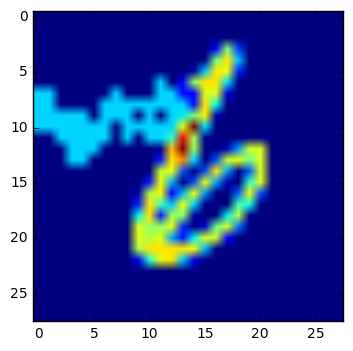

In [23]:
%matplotlib inline
done = False
observation = env.reset() # reset env
agent.epsilon=0.2
import copy
while not done:
    x = observation
    
#     feed = {agent.x: np.reshape(x, (1,-1)), agent.actor.params['istate'].c: c, agent.actor.params['istate'].h: h}
#     fetch = [agent.y_hat, agent.actor.params['fstate'].c, agent.actor.params['fstate'].h]
#     [y_hat, c, h] = agent.sess.run(fetch, feed)
#     print y_hat[0,:4]
        
    action = agent.act(np.reshape(x, (1,-1)))
    observation, reward, done, info = env.step(action)

plt.figure(0)
plt.imshow(env.canvas + 2*env.template)
# plt.imshow(np.reshape(observation,(28,28)))